In [1]:
from astropy.io import fits
from astropy.table import Table, join, unique

from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.xmatch import XMatch
from astropy.utils.metadata import merge

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Could not import regions, which is required for some of the functionalities of this module.


In [2]:
catalog = Table.read('https://data.sdss.org/sas/dr17/manga/spectro/mastar/v3_1_1/v1_7_7/mastarall-v3_1_1-v1_7_7.fits')
ir_table = Table.read('data/01_ir_excess.fits')

In [3]:
psf_u = []
psf_g = []
psf_r = []
psf_i = []
psf_z = []

for i in tqdm(range(len(catalog))):
    mu,g,r,i,z = catalog['PSFMAG'][i]
    
    psf_u.append(mu) 
    psf_g.append(g) 
    psf_r.append(r) 
    psf_i.append(i) 
    psf_z.append(z) 
    
catalog.rename_columns(['RA','DEC'], ['ra','dec'])
    
catalog.remove_column('PSFMAG')
catalog['u'] = psf_u
catalog['g'] = psf_g
catalog['r'] = psf_r
catalog['i'] = psf_i
catalog['z'] = psf_z

100%|██████████| 24290/24290 [00:00<00:00, 434831.19it/s]


In [4]:
# 	II/328/allwise

table = XMatch.query(cat1=catalog,
                     cat2='vizier:II/328/allwise',
                     max_distance=10 * u.arcsec, colRA1='ra',
                     colDec1='dec')

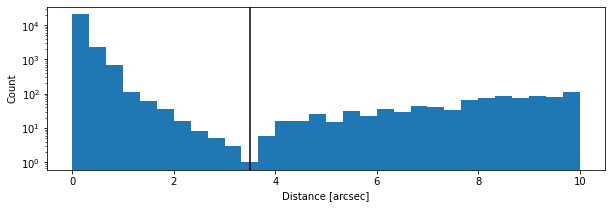

In [5]:
plt.figure(figsize = (10,3))
plt.hist(table['angDist'], bins = 30)
plt.axvline(x = 3.5, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')
plt.yscale('log')

table = table[table['angDist'] < 3.5]

In [6]:
table = table[table['z'] > -900]

table.remove_columns(['eeMaj','eeMin','eePA','W1mag','W2mag','W3mag','W4mag',
                           'Jmag','Hmag','Kmag','e_W1mag','e_W2mag','e_W3mag','e_W4mag','e_Jmag','e_Hmag','e_Kmag',\
                           'ID','ccf','ex','var','qph','pmRA','e_pmRA','pmDE','e_pmDE','d2M'])

In [7]:
table[0]

angDist,DRPVER,MPROCVER,MANGAID,MINMJD,MAXMJD,NVISITS,NPLATES,ra,dec,EPOCH,MNGTARG2,INPUT_LOGG,INPUT_TEFF,INPUT_FE_H,INPUT_ALPHA_M,INPUT_SOURCE,PHOTOCAT,u,g,r,i,z,AllWISE,RAJ2000,DEJ2000
arcsec,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
float64,str6,str6,str22,int32,int32,int16,int16,float64,float64,float64,int32,float64,float64,float64,float64,str14,str9,float64,float64,float64,float64,float64,str19,float64,float64
0.50676,v3_1_1,v1_7_7,13-0,56741,56745,3,1,231.01780658696867,41.913900785404856,2003.3238525390625,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,16.26342010498047,15.38846206665039,15.056318283081055,14.935285568237305,14.904105186462402,J152404.23+415449.7,231.0176601,41.9138117


In [8]:
import os
from astropy.io import ascii
from astropy.table import join, unique

ascii.write(table[['AllWISE','RAJ2000', 'DEJ2000']], 'upload.tbl', overwrite=True, format='ipac')  

os.system('curl -o fp_psc.tbl -F "UPLOAD=my_table,param:table.tbl" -F "table.tbl=@upload.tbl" \
          -F "FORMAT=IPAC_TABLE" -F "QUERY=SELECT * FROM allwise_p3as_psd \
          WHERE CONTAINS(POINT(ra,dec), CIRCLE(TAP_UPLOAD.my_table.RAJ2000, TAP_UPLOAD.my_table.DEJ2000, 0.01)) =1" https://irsa.ipac.caltech.edu/TAP/sync ')

os.system('rm upload.tbl')
test = Table.read('fp_psc.tbl', format = 'ascii')
os.system('rm fp_psc.tbl')

table.remove_columns(['RAJ2000', 'DEJ2000'])

catalog = unique(join(table, test, keys_left = 'AllWISE', keys_right = 'designation', join_type = 'left'), keys = 'designation')

In [14]:
catalog.remove_column('z_2')
catalog.rename_column('z_1', 'z')

In [15]:
catalog[0:2]

angDist,DRPVER,MPROCVER,MANGAID,MINMJD,MAXMJD,NVISITS,NPLATES,ra_1,dec_1,EPOCH,MNGTARG2,INPUT_LOGG,INPUT_TEFF,INPUT_FE_H,INPUT_ALPHA_M,INPUT_SOURCE,PHOTOCAT,u,g,r,i,z,AllWISE,designation,ra_2,dec_2,sigra,sigdec,sigradec,glon,glat,elon,elat,wx,wy,cntr,source_id,coadd_id,src,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,satnum,ra_pm,dec_pm,sigra_pm,sigdec_pm,sigradec_pm,pmra,sigpmra,pmdec,sigpmdec,w1rchi2_pm,w2rchi2_pm,w3rchi2_pm,w4rchi2_pm,rchi2_pm,pmcode,cc_flags,rel,ext_flg,var_flg,ph_qual,det_bit,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,w1cov,w2cov,w3cov,w4cov,w1cc_map,w1cc_map_str,w2cc_map,w2cc_map_str,w3cc_map,w3cc_map_str,w4cc_map,w4cc_map_str,best_use_cntr,ngrp,w1flux,w1sigflux,w1sky,w1sigsk,w1conf,w2flux,w2sigflux,w2sky,w2sigsk,w2conf,w3flux,w3sigflux,w3sky,w3sigsk,w3conf,w4flux,w4sigflux,w4sky,w4sigsk,w4conf,w1mag,w1sigm,w1flg,w1mcor,w2mag,w2sigm,w2flg,w2mcor,w3mag,w3sigm,w3flg,w3mcor,w4mag,w4sigm,w4flg,w4mcor,w1mag_1,w1sigm_1,w1flg_1,w2mag_1,w2sigm_1,w2flg_1,w3mag_1,w3sigm_1,w3flg_1,w4mag_1,w4sigm_1,w4flg_1,w1mag_2,w1sigm_2,w1flg_2,w2mag_2,w2sigm_2,w2flg_2,w3mag_2,w3sigm_2,w3flg_2,w4mag_2,w4sigm_2,w4flg_2,w1mag_3,w1sigm_3,w1flg_3,w2mag_3,w2sigm_3,w2flg_3,w3mag_3,w3sigm_3,w3flg_3,w4mag_3,w4sigm_3,w4flg_3,w1mag_4,w1sigm_4,w1flg_4,w2mag_4,w2sigm_4,w2flg_4,w3mag_4,w3sigm_4,w3flg_4,w4mag_4,w4sigm_4,w4flg_4,w1mag_5,w1sigm_5,w1flg_5,w2mag_5,w2sigm_5,w2flg_5,w3mag_5,w3sigm_5,w3flg_5,w4mag_5,w4sigm_5,w4flg_5,w1mag_6,w1sigm_6,w1flg_6,w2mag_6,w2sigm_6,w2flg_6,w3mag_6,w3sigm_6,w3flg_6,w4mag_6,w4sigm_6,w4flg_6,w1mag_7,w1sigm_7,w1flg_7,w2mag_7,w2sigm_7,w2flg_7,w3mag_7,w3sigm_7,w3flg_7,w4mag_7,w4sigm_7,w4flg_7,w1mag_8,w1sigm_8,w1flg_8,w2mag_8,w2sigm_8,w2flg_8,w3mag_8,w3sigm_8,w3flg_8,w4mag_8,w4sigm_8,w4flg_8,w1magp,w1sigp1,w1sigp2,w1k,w1ndf,w1mlq,w1mjdmin,w1mjdmax,w1mjdmean,w2magp,w2sigp1,w2sigp2,w2k,w2ndf,w2mlq,w2mjdmin,w2mjdmax,w2mjdmean,w3magp,w3sigp1,w3sigp2,w3k,w3ndf,w3mlq,w3mjdmin,w3mjdmax,w3mjdmean,w4magp,w4sigp1,w4sigp2,w4k,w4ndf,w4mlq,w4mjdmin,w4mjdmax,w4mjdmean,rho12,rho23,rho34,q12,q23,q34,xscprox,w1rsemi,w1ba,w1pa,w1gmag,w1gerr,w1gflg,w2rsemi,w2ba,w2pa,w2gmag,w2gerr,w2gflg,w3rsemi,w3ba,w3pa,w3gmag,w3gerr,w3gflg,w4rsemi,w4ba,w4pa,w4gmag,w4gerr,w4gflg,tmass_key,r_2mass,pa_2mass,n_2mass,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,x,y,spt_ind,htm20
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,arcsec,deg,deg,deg,deg,pix,pix,,,,,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,,,,,,,deg,deg,arcsec,arcsec,arcsec,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,DN,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,mag,,,,,,,mag,mag,mag,,,,,,,mag,mag,mag,,,,,,,mag,mag,mag,,,,,,,%,%,%,,,,arcsec,arcsec,,deg,mag,mag,,arcsec,,deg,mag,mag,,arcsec,,deg,mag,mag,,arcsec,,deg,mag,mag,,,arcsec,deg,,mag,mag,mag,mag,mag,mag,,,,
float64,str6,str6,str22,int32,int32,int16,int16,float64,float64,float64,int32,float64,float64,float64,float64,str14,str9,float64,float64,float64,float64,float64,str19,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str20,str13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,str5,str4,str1,int64,str4,str4,int64,str4,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str3,int64,str3

In [32]:
not catalog['w1cc_map_str'][0]

True

In [33]:
snr_thresh = 10

snr_mask = np.all([catalog['w1snr'] > snr_thresh, catalog['w2snr'] > snr_thresh], axis = 0)
contamination_mask = np.all([catalog['w1cc_map_str'] == None, catalog['w2cc_map_str'] == None], axis = 0)

mask = np.any([snr_mask, contamination_mask], axis = 0)

Text(0, 0.5, 'Count')

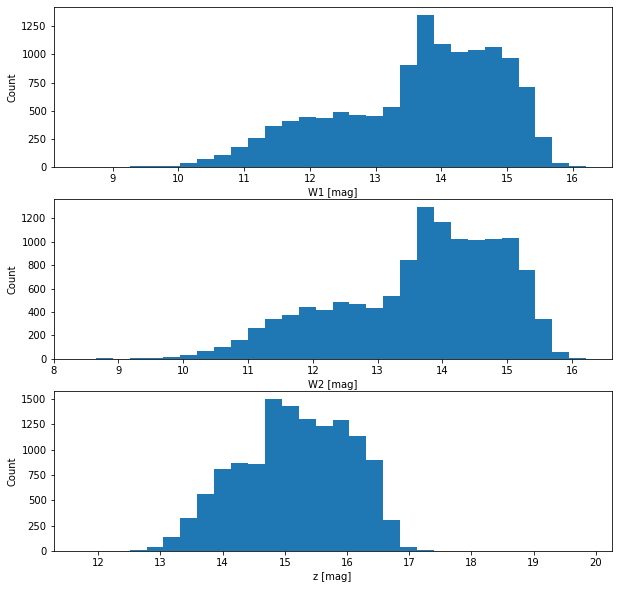

In [34]:
plt.figure(figsize = (10,10))

plt.subplot(3,1,1)
plt.hist(catalog[mask]['w1mpro'], bins = 30)
plt.xlabel('W1 [mag]')
plt.ylabel('Count')

plt.subplot(3,1,2)
plt.hist(catalog[mask]['w2mpro'], bins = 30)
plt.xlabel('W2 [mag]')
plt.ylabel('Count')

plt.subplot(3,1,3)
plt.hist(catalog[mask]['z'], bins = 30)
plt.xlabel('z [mag]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

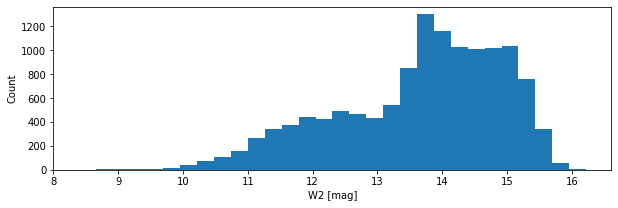

In [35]:
plt.figure(figsize = (10,3))
plt.hist(catalog[mask]['w2mpro'], bins = 30)
plt.xlabel('W2 [mag]')
plt.ylabel('Count')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'z - W1')

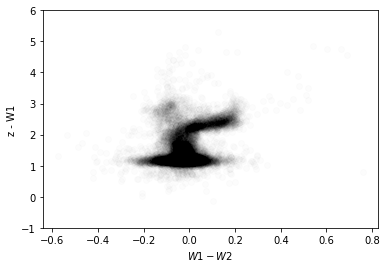

In [36]:
plt.scatter(catalog[mask]['w1mpro'] - catalog[mask]['w2mpro'], 
            catalog[mask]['z'] - catalog[mask]['w1mpro'], c = 'k', alpha = 0.01)

plt.legend(framealpha = 0)

plt.ylim(-1,6)

plt.xlabel(r'$W1 - W2$')
plt.ylabel(r'z - W1')

In [37]:
table

angDist,DRPVER,MPROCVER,MANGAID,MINMJD,MAXMJD,NVISITS,NPLATES,ra,dec,EPOCH,MNGTARG2,INPUT_LOGG,INPUT_TEFF,INPUT_FE_H,INPUT_ALPHA_M,INPUT_SOURCE,PHOTOCAT,u,g,r,i,z,AllWISE
arcsec,,,,,,,,,,,,,,,,,,,,,,,
float64,str6,str6,str22,int32,int32,int16,int16,float64,float64,float64,int32,float64,float64,float64,float64,str14,str9,float64,float64,float64,float64,float64,str19
0.50676,v3_1_1,v1_7_7,13-0,56741,56745,3,1,231.01780658696867,41.913900785404856,2003.3238525390625,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,16.26342010498047,15.38846206665039,15.056318283081055,14.935285568237305,14.904105186462402,J152404.23+415449.7
0.059287,v3_1_1,v1_7_7,13-1,56741,56745,3,1,230.9779115513416,41.51587852720575,2003.3238525390625,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,16.86233139038086,15.924821853637695,15.65964126586914,15.5343656539917,15.488884925842285,J152354.69+413057.1
0.136465,v3_1_1,v1_7_7,13-10,56741,56745,3,1,229.95203771283292,42.26929773840978,2003.406005859375,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,17.795345306396484,16.83037757873535,16.48142433166504,16.35013198852539,16.309675216674805,J151948.48+421609.3
0.234272,v3_1_1,v1_7_7,13-11,56741,56745,3,1,232.324225827951,43.63022552248515,2002.34912109375,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,17.83548927307129,16.88359260559082,16.57887077331543,16.469959259033203,16.463754653930664,J152917.81+433748.5
0.271502,v3_1_1,v1_7_7,13-2,56741,56745,3,1,230.6423911232239,42.44738739379231,2003.406005859375,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,18.878772735595703,17.965349197387695,17.626436233520508,17.506271362304688,17.46255874633789,J152234.18+422650.3
0.294631,v3_1_1,v1_7_7,13-3,56741,56745,3,1,232.72585353713853,42.64115839395187,2003.3238525390625,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,16.91095733642578,16.07996940612793,15.797928810119629,15.705500602722168,15.666540145874023,J153054.18+423828.2
0.05549,v3_1_1,v1_7_7,13-4,56741,56745,3,1,230.52275999424432,43.01072841449852,2003.406005859375,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,17.18383026123047,16.255647659301758,15.943817138671875,15.811674118041992,15.725769996643066,J152205.45+430038.6
0.139209,v3_1_1,v1_7_7,13-5,56741,56745,3,1,232.69787967597313,43.33482968028721,2002.34912109375,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,17.264123916625977,16.334346771240234,16.10478973388672,15.976034164428711,16.004669189453125,J153047.49+432005.2
